# Pruba HDI
## Max Benjamín Austria Salazar

- El objetivo es crear un modelo de regresión adecuado para la Frecuencia, y otro para la Severidad, utilizando algunas de las variables compartidas como variables explicativas.

$Frecuencia = \frac{NumSiniestros}{UnidadesExpuestas}$

$Severidad = \frac{MontoOcurrido}{NumSiniestros}$

$Precio = Frecuencia * Severidad$

- Como entregable hay que proporcionar el código para generar dichos modelos, la validación con las métricas respectivas,

- y por último, la tabla con la predicción de la Frecuencia y Severidad para cada uno de los registros.

- Hay que añadir la columna de Precio, multiplicando las predicciones de Frecuencia y Severidad respectivamente

### Paquetes

In [1]:
#Para las gráficas
library(dplyr)
library(ggplot2)
library(ggfortify)
library(ranger)
library(ggpubr)
library(lattice)

#Para el análisis
library(glmmTMB)#Otra opción es Rfast2
#library(statmod)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




#### Cargando los datos

In [2]:
#Carga de los datos
datos <- readr::read_csv(file = "datos.csv", locale = readr::locale(encoding = "ISO-8859-1"))

#Formateando
datos$Anio = as.factor(datos$Anio)
datos$ID = as.character(datos$ID)
datos$NombreSubdireccion = as.factor(datos$NombreSubdireccion)
datos$DescTipoVehiculo = as.factor(datos$DescTipoVehiculo)
datos$TipoPersona = as.factor(datos$TipoPersona)
datos$Edad = as.integer(datos$Edad)
datos$Sexo = as.factor(datos$Sexo)
datos$DescMarcaVehiculo = as.factor(datos$DescMarcaVehiculo)
datos$DescCarroceriaVehiculo = as.factor(datos$DescCarroceriaVehiculo)
datos$ModeloVehiculo = as.integer(datos$ModeloVehiculo)
datos$DescUsoVehiculo = as.factor(datos$DescUsoVehiculo)
#datos$UnidadesExpuestas = abs(datos$UnidadesExpuestas)

#Ejemplo
head(datos)


Rows: 50000 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): NombreOficina, NombreSubdireccion, DescTipoVehiculo, TipoPersona, D...
dbl (9): Anio, ID, UnidadesExpuestas, Edad, Sexo, ModeloVehiculo, PrimaNetaP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Anio,ID,NombreOficina,UnidadesExpuestas,NombreSubdireccion,DescTipoVehiculo,TipoPersona,Edad,Sexo,DescMarcaVehiculo,DescCarroceriaVehiculo,ModeloVehiculo,DescUsoVehiculo,PrimaNetaPropiaSinCoaseguro,MontoOcurrido,NumSiniestros
<fct>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>
2021,40480000012367,048 Croz Promotores,0.0000000,Promotorias Guadalajara,Vehiculos Residentes,Fisica,60,2,MAZDA,MAZDA CX-9,2009,AUTOMÓVILES RESIDENTES,0.000,0,0
2020,42730000831079,273 Morris,0.0000000,Noroeste,Pick Up,Fisica,58,1,CHEVROLET,SILVERADO 2500,2014,CARGA COMERCIAL,1484.953,0,0
2021,40100001237795,010 Queretaro,0.0000000,Centro,Vehiculos Residentes,Fisica,54,1,NISSAN,TIIDA,2013,AUTOMÓVILES RESIDENTES,0.000,0,0
2019,40740000829763,074 Telemarketing Corporativo,0.1589041,Telemarketing,Pick Up,Fisica,47,1,CHEVROLET,EXPRESS VAN,2012,PICK UP FAMILIAR,1680.102,0,0
2019,40980000054921,098 Abs Actuarios Consultores Sociedad Civil,0.3287671,Promotorias México Sur,Vehiculos Residentes,Fisica,66,1,HONDA,FIT,2007,AUTOMÓVILES RESIDENTES,0.000,0,0
2021,40570001238666,057 Mochis,0.9698630,Noroeste,Vehiculos Residentes,Fisica,41,1,VOLKSWAGEN,JETTA NUEVO A6,2012,AUTOMÓVILES RESIDENTES,0.000,0,0


## Estadística Descriptiva

#### Estadística descriptiva entre las variables: MontoOcurrido, NumSiniestros, UnidadesExpuestas.

In [3]:
col = which(colnames(datos) %in% c("MontoOcurrido", "NumSiniestros", "UnidadesExpuestas"))
cor(datos[,col])

,UnidadesExpuestas,MontoOcurrido,NumSiniestros
UnidadesExpuestas,1.00000000,0.07868049,0.2084499
MontoOcurrido,0.07868049,1.00000000,0.3500598
NumSiniestros,0.20844989,0.35005984,1.0000000


In [4]:
summary(datos[,col])

 UnidadesExpuestas  MontoOcurrido      NumSiniestros    
 Min.   :-0.99178   Min.   :     0.0   Min.   :0.00000  
 1st Qu.: 0.00000   1st Qu.:     0.0   1st Qu.:0.00000  
 Median : 0.09041   Median :     0.0   Median :0.00000  
 Mean   : 0.25217   Mean   :   828.6   Mean   :0.03916  
 3rd Qu.: 0.48219   3rd Qu.:     0.0   3rd Qu.:0.00000  
 Max.   : 1.00274   Max.   :904414.3   Max.   :5.00000  

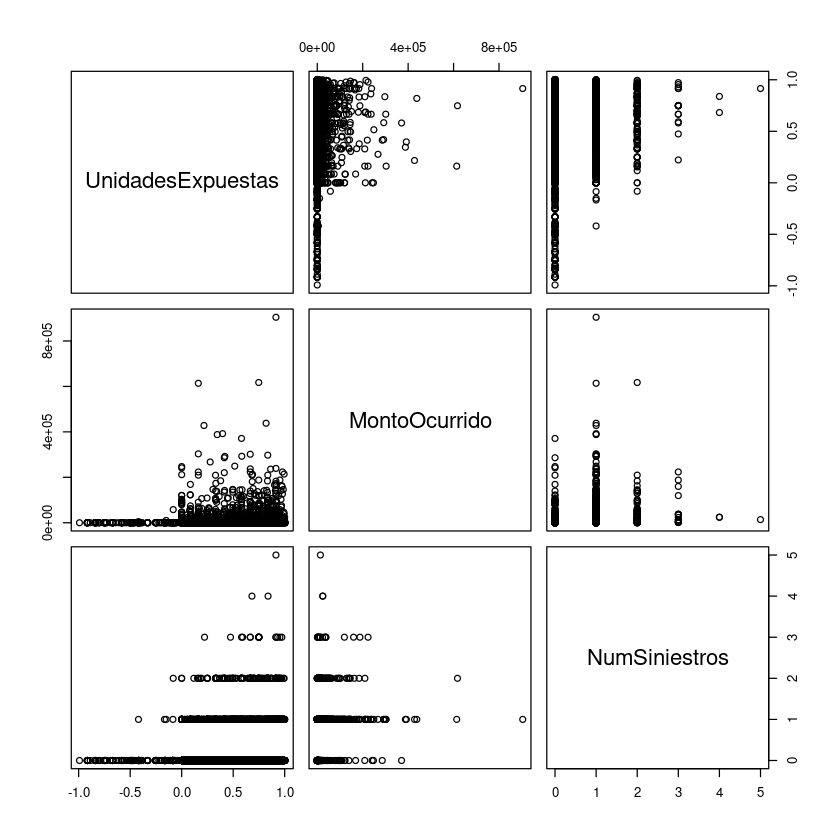

In [5]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(datos[,col])

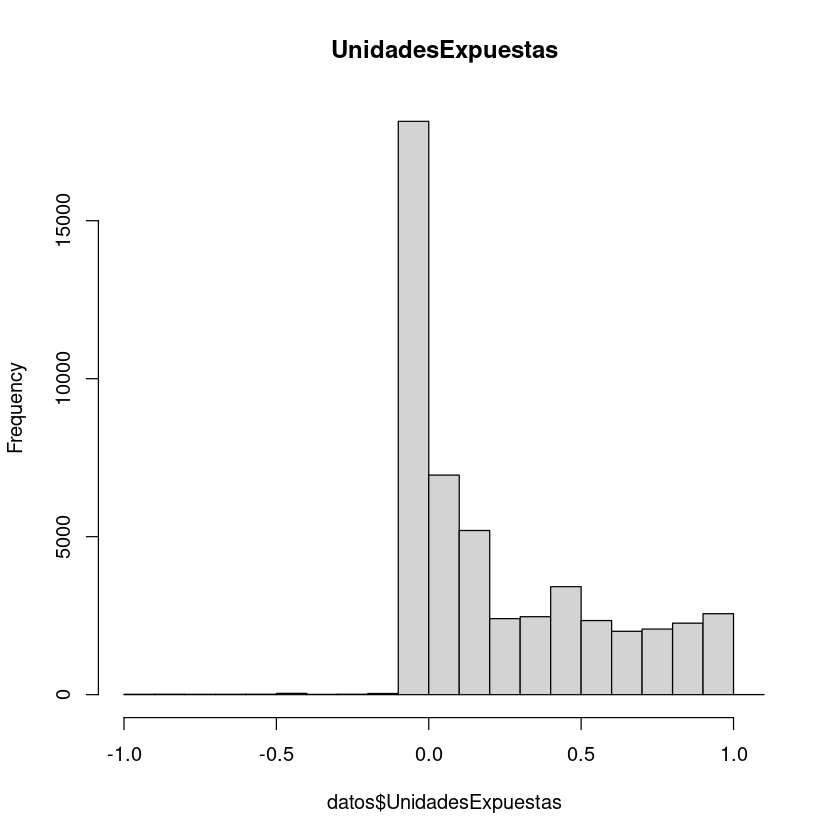

In [6]:
hist(datos$UnidadesExpuestas, main ="UnidadesExpuestas", breaks = 25)

##### Observación.

Hay valores negativos en variables que (en principio) deberían ser positivas. Por ahora voy a trabajar con el valor absoluto, pues considero que el signo debe ser por algún tema contable.

In [7]:
col = which(colnames(datos) %in% c("UnidadesExpuestas","PrimaNetaPropiaSinCoaseguro"))
datos[which(datos$UnidadesExpuestas<0),col]

UnidadesExpuestas,PrimaNetaPropiaSinCoaseguro
<dbl>,<dbl>
-0.076712329,-711.0069
-0.052054795,-1733.8314
-0.249315069,0.0000
-0.084931507,-1872.4415
-0.471232878,-874.9088
-0.016438356,-109.1596
-0.504109590,-698.6279
-0.394520549,-821.0379
-0.419178083,-3269.4355


##### Limpiando los datos

In [8]:
datos$signo = sign(datos$UnidadesExpuestas)
datos$UnidadesExpuestas = abs(datos$UnidadesExpuestas)

Las siguientes expresiones deberían ser ciertas:

- $UnidadesExpuestas= 0 \implies NumSiniestros = 0$.

- $NumSiniestros = 0 \implies MontoOcurrido = 0$.

Por lo que, de no cumplirse, se debe corregir.

In [9]:
col = which(colnames(datos) %in% c("MontoOcurrido", "NumSiniestros", "UnidadesExpuestas"))
ind = which((datos$UnidadesExpuestas == 0) & (datos$NumSiniestros!=0))
datos[ind,col]

UnidadesExpuestas,MontoOcurrido,NumSiniestros
<dbl>,<dbl>,<dbl>
0,0.0000,1
0,0.0000,1
0,0.0000,1
0,5043.9358,2
0,20191.1836,1
0,44900.4715,1
0,211662.2741,1
0,1498.5651,1
0,714.2900,1


Como son pocas observaciones que no cumplen con la regla ($UnidadesExpuestas= 0 \implies NumSiniestros = 0$), las voy a quitar.

In [10]:
datos = datos[-ind,]

La segunda regla ($NumSiniestros = 0 \implies MontoOcurrido = 0$), también se rompe en pocas ocasiones, por lo que también se borran las observaciones.

In [11]:
ind = which((datos$MontoOcurrido != 0) & (datos$NumSiniestros==0))
print(paste0("Número de observaciones irregulares: ",dim(datos[ind,col])[1]))
datos[ind,col]

[1] "Número de observaciones irregulares: 253"


UnidadesExpuestas,MontoOcurrido,NumSiniestros
<dbl>,<dbl>,<dbl>
0.08493151,4599.882,0
0.49589041,9706.784,0
0.66849315,1528.879,0
0.00000000,3218.671,0
0.66575343,20839.481,0
0.00000000,1005.120,0
0.00000000,2781.929,0
0.16438356,3908.783,0
0.33972603,89913.716,0


In [12]:
datos = datos[-ind,]

In [13]:
dim(datos)
length(apply(datos[,col],1,function(x){if(x[3] == 0){0}else{x[3]/x[1]}}))

[1] 49713    17

[1] 49713

### Cálculo de las variables: Frecuencia y Severidad.

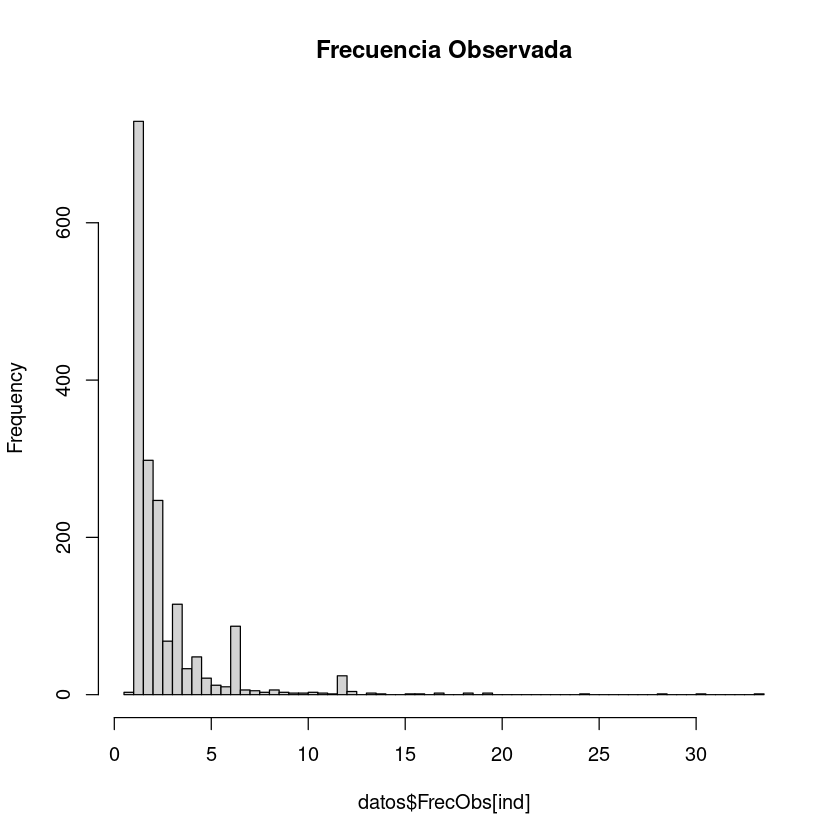

In [14]:
#Cálculo de la frecuencia observada
datos$FrecObs = apply(datos[,col],1,function(x){if(x[3] == 0){0}else{x[3]/x[1]}})
ind = which(datos$FrecObs>0)
hist(datos$FrecObs[ind], main="Frecuencia Observada", breaks = 50)

Sólo 1747 observaciones tienen una frecuencia mayor a cero.

In [15]:
length(ind)

[1] 1747

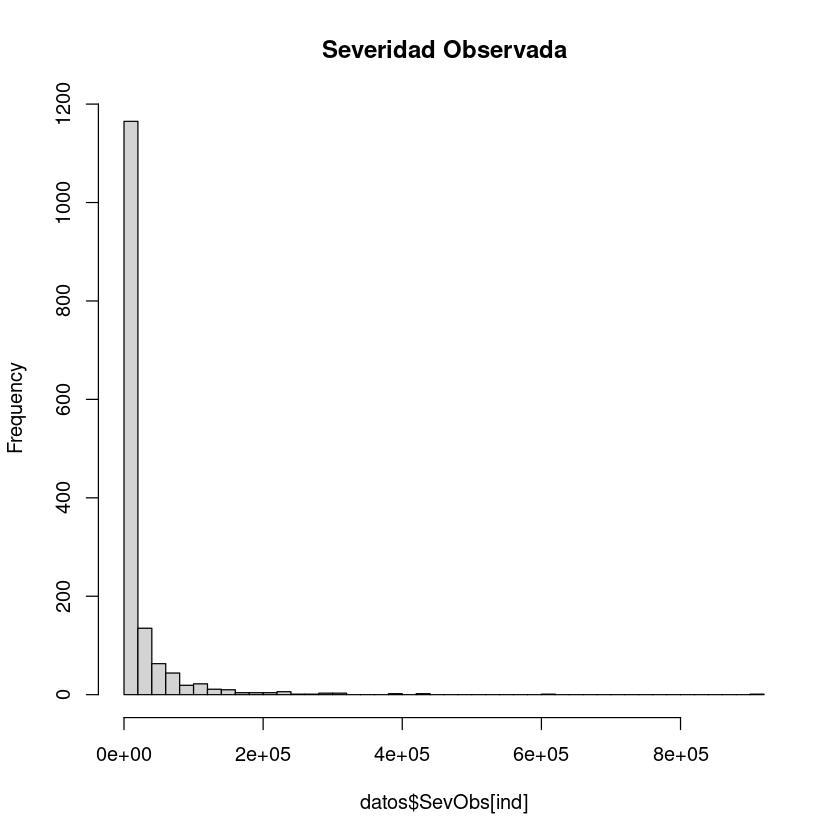

In [16]:
#Cálculo de la severidad observada
datos$SevObs = apply(datos[,col],1,function(x){if(x[2] == 0){0}else{x[2]/x[3]}})
ind = which(datos$SevObs>0)
hist(datos$SevObs[ind], main="Severidad Observada", breaks = 50)

Sólo 1501 observaciones tienen una severidad mayor a cero.

In [17]:
length(ind)

[1] 1501

In [18]:
datos$Anio = as.factor(datos$Anio)

#### Estadística descriptiva del resto de variables.

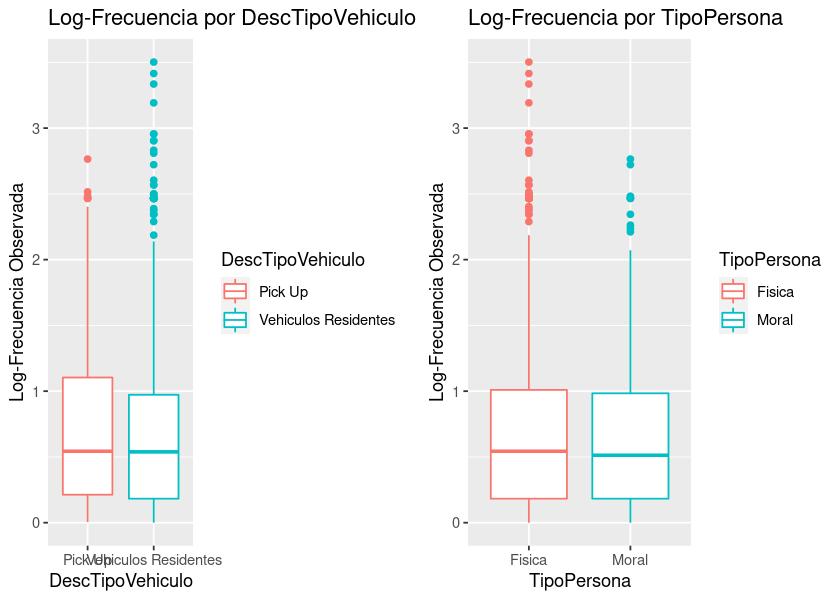

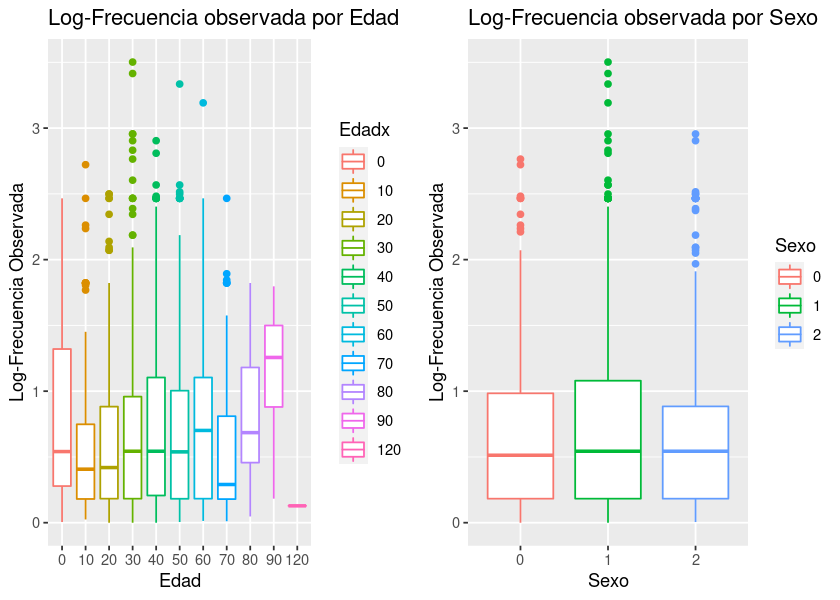

In [19]:
#Estadística para la Frecuencia Observada

ind = which(datos$FrecObs>0)

img1 = ggplot(datos[ind,], aes(x = DescTipoVehiculo, y = log(FrecObs), color = DescTipoVehiculo)) + geom_boxplot()+
labs(title = "Log-Frecuencia por DescTipoVehiculo", y= "Log-Frecuencia Observada", x = "DescTipoVehiculo")

img2 = ggplot(datos[ind,], aes(x = TipoPersona, y = log(FrecObs), color = TipoPersona)) + geom_boxplot()+
labs(title = "Log-Frecuencia por TipoPersona", y= "Log-Frecuencia Observada", x = "TipoPersona")

datos$Edadx = as.factor(as.integer(datos$Edad /10)*10)
img3 = ggplot(datos[ind,], aes(x = Edadx, y = log(FrecObs), color = Edadx)) + geom_boxplot()+
labs(title = "Log-Frecuencia observada por Edad", y= "Log-Frecuencia Observada", x = "Edad")

img4 = ggplot(datos[ind,], aes(x = Sexo, y = log(FrecObs), color = Sexo)) + geom_boxplot()+
labs(title = "Log-Frecuencia observada por Sexo", y= "Log-Frecuencia Observada", x = "Sexo")

datos$ModeloVehiculo = as.factor(datos$ModeloVehiculo)
img5 = ggplot(datos[ind,], aes(x = ModeloVehiculo, y = log(FrecObs), color = ModeloVehiculo)) + geom_boxplot()+
labs(title = "Log-Frecuencia observada por ModeloVehiculo", y= "Log-Frecuencia Observada", x = "ModeloVehiculo")
datos$ModeloVehiculo = as.integer(datos$ModeloVehiculo)


img6 = ggplot(datos[ind,], aes(x = DescUsoVehiculo, y = log(FrecObs), color = DescUsoVehiculo)) + geom_boxplot()+
labs(title = "Log-Frecuencia observada por DescUsoVehiculo", y= "Log-Frecuencia DescUsoVehiculo", x = "DescUsoVehiculo")

img7 = ggplot(datos[ind,], aes(x = DescMarcaVehiculo, y = log(FrecObs), color = DescMarcaVehiculo)) + geom_boxplot()+
labs(title = "Log-Frecuencia observada por DescMarcaVehiculo", y= "Log-Frecuencia DescMarcaVehiculo", x = "DescUsoVehiculo")


options( repr.plot.height = 5)
ggarrange(img1,img2, ncol = 2)
ggarrange(img3,img4, ncol = 2)

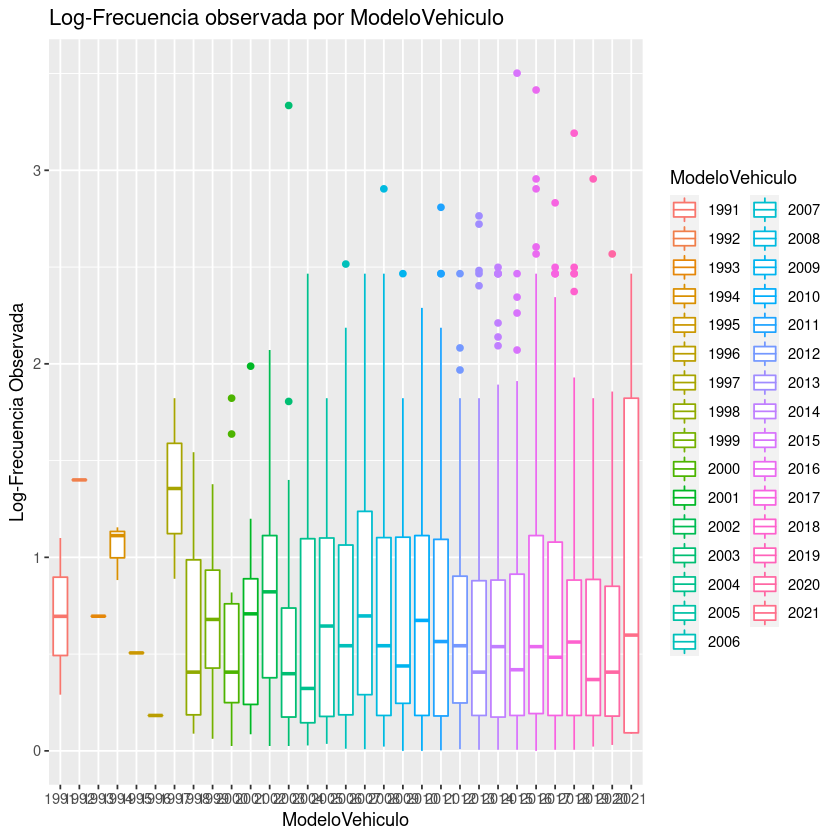

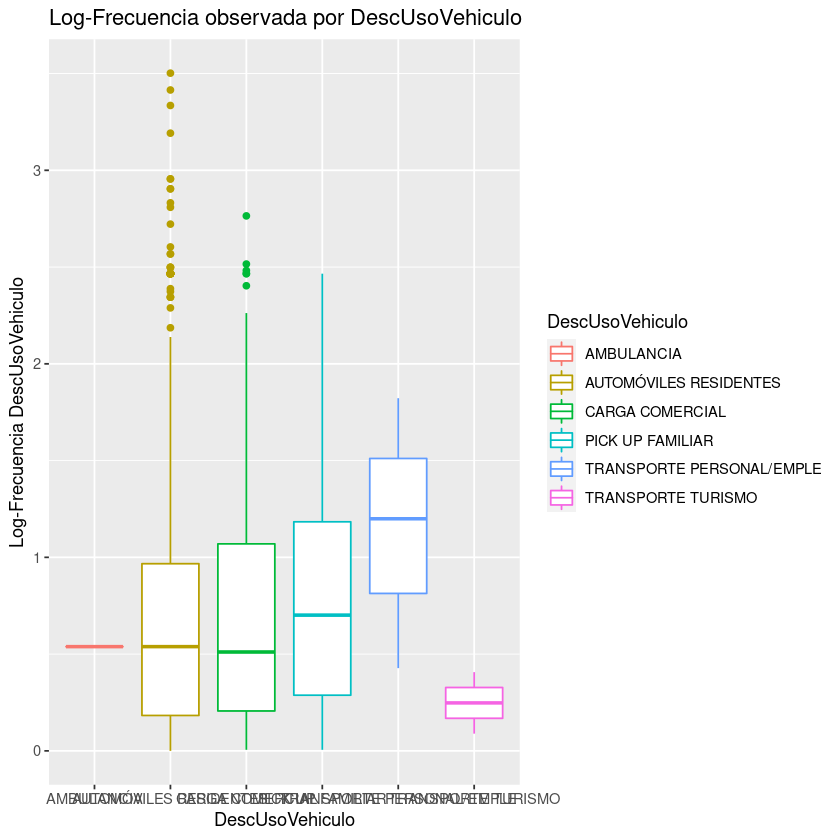

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)
img5
img6

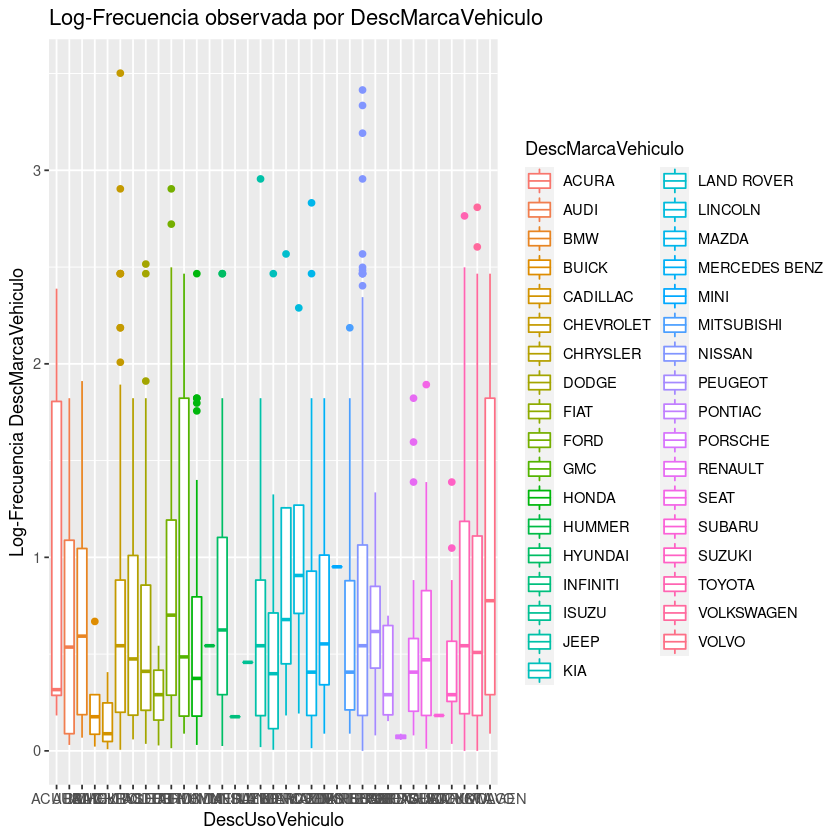

In [21]:
img7

##### Observación.

De los diagramas anteriores, sugieren que las mejores variables que más reflejan la variabilidad de la frecuencia pueden ser:

- DescUsoVehiculo: En especial el Transporte para Turismo y de Personal.

- Edad: Sobre todo, en edades mayores a los 50 años.

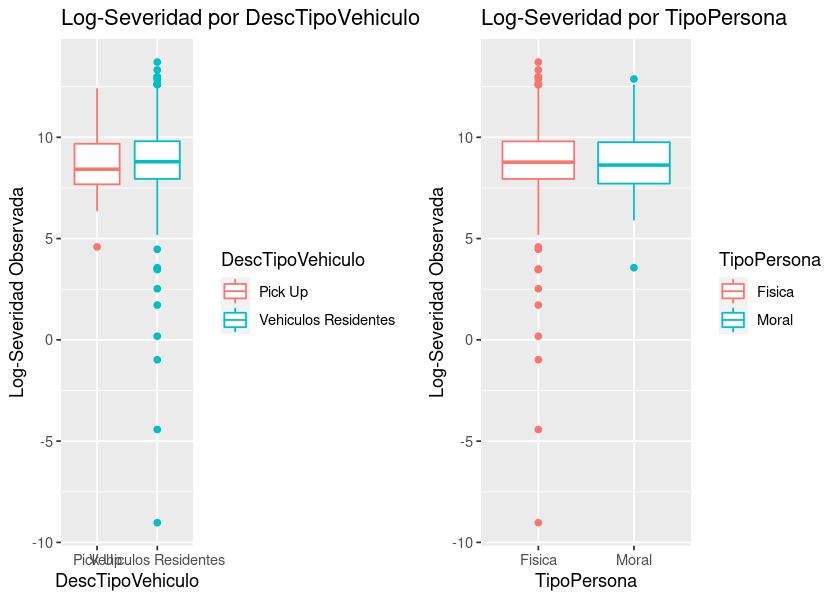

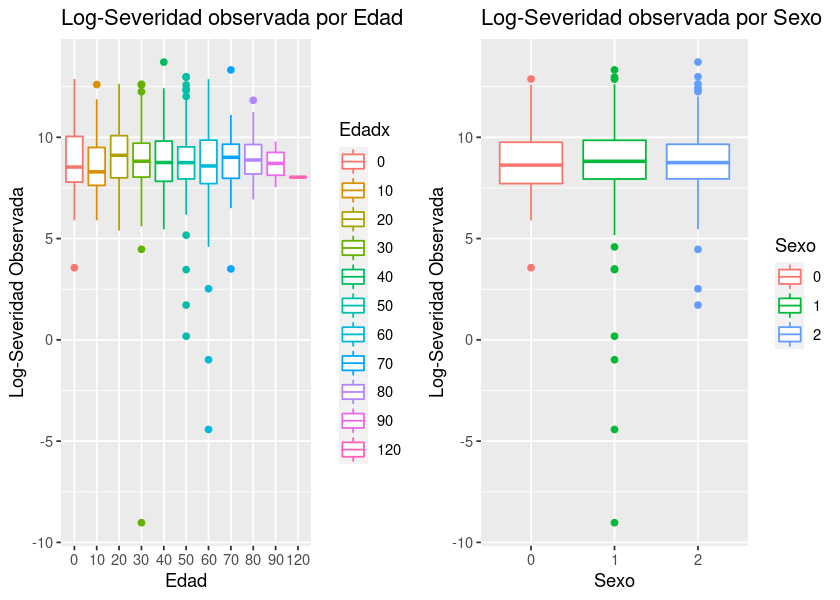

In [22]:
#Estadística para la Severidad Observada

ind = which(datos$SevObs>0)

img1 = ggplot(datos[ind,], aes(x = DescTipoVehiculo, y = log(SevObs), color = DescTipoVehiculo)) + geom_boxplot()+
labs(title = "Log-Severidad por DescTipoVehiculo", y= "Log-Severidad Observada", x = "DescTipoVehiculo")

img2 = ggplot(datos[ind,], aes(x = TipoPersona, y = log(SevObs), color = TipoPersona)) + geom_boxplot()+
labs(title = "Log-Severidad por TipoPersona", y= "Log-Severidad Observada", x = "TipoPersona")

datos$Edadx = as.factor(as.integer(datos$Edad /10)*10)
img3 = ggplot(datos[ind,], aes(x = Edadx, y = log(SevObs), color = Edadx)) + geom_boxplot()+
labs(title = "Log-Severidad observada por Edad", y= "Log-Severidad Observada", x = "Edad")

img4 = ggplot(datos[ind,], aes(x = Sexo, y = log(SevObs), color = Sexo)) + geom_boxplot()+
labs(title = "Log-Severidad observada por Sexo", y= "Log-Severidad Observada", x = "Sexo")

datos$ModeloVehiculo = as.factor(datos$ModeloVehiculo)
img5 = ggplot(datos[ind,], aes(x = ModeloVehiculo, y = log(SevObs), color = ModeloVehiculo)) + geom_boxplot()+
labs(title = "Log-Severidad observada por ModeloVehiculo", y= "Log-Severidad Observada", x = "ModeloVehiculo")
datos$ModeloVehiculo = as.integer(datos$ModeloVehiculo)


img7 = ggplot(datos[ind,], aes(x = DescMarcaVehiculo, y = log(SevObs), color = DescMarcaVehiculo)) + geom_boxplot()+
labs(title = "Log-Severidad observada por DescMarcaVehiculo", y= "Log-Severidad DescMarcaVehiculo", x = "DescUsoVehiculo")

options( repr.plot.height = 5)
ggarrange(img1,img2, ncol = 2)
ggarrange(img3,img4, ncol = 2)

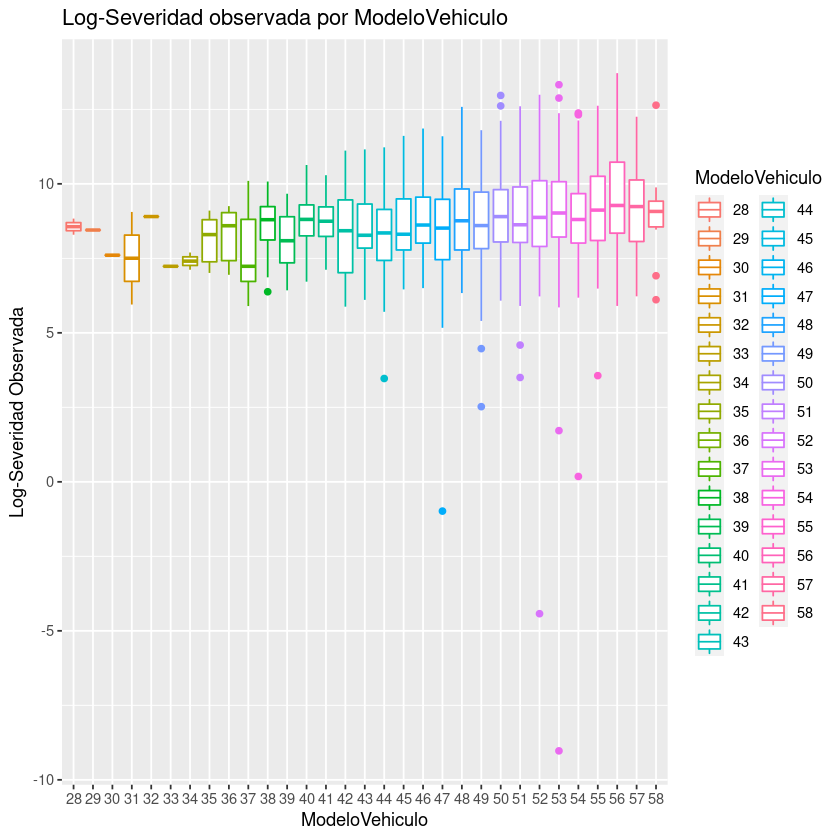

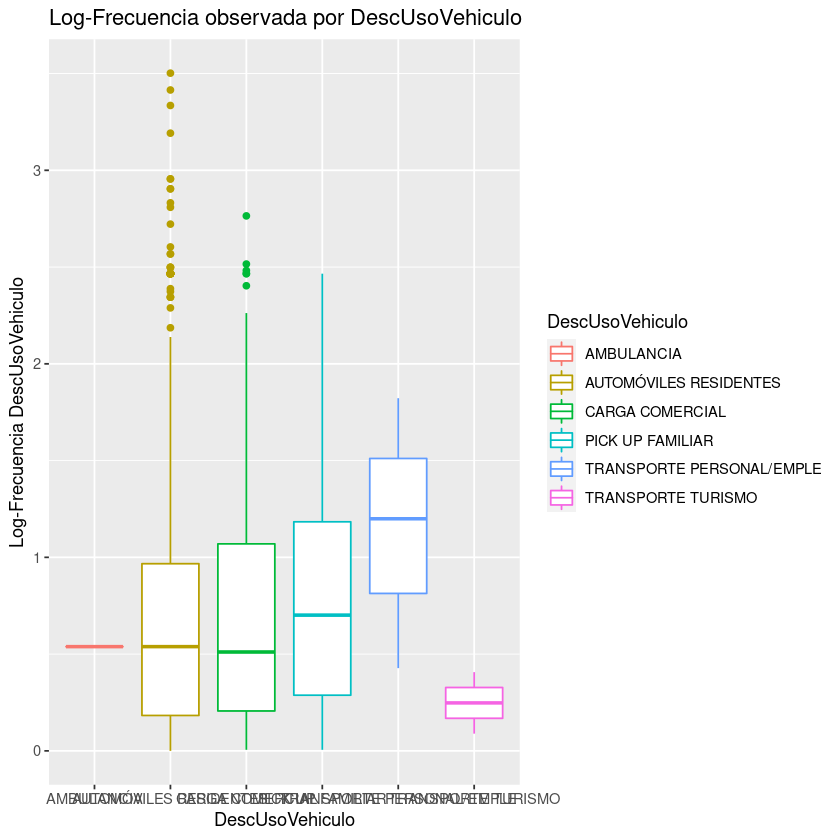

In [23]:
options(repr.plot.width = 7, repr.plot.height = 7)
img5
img6

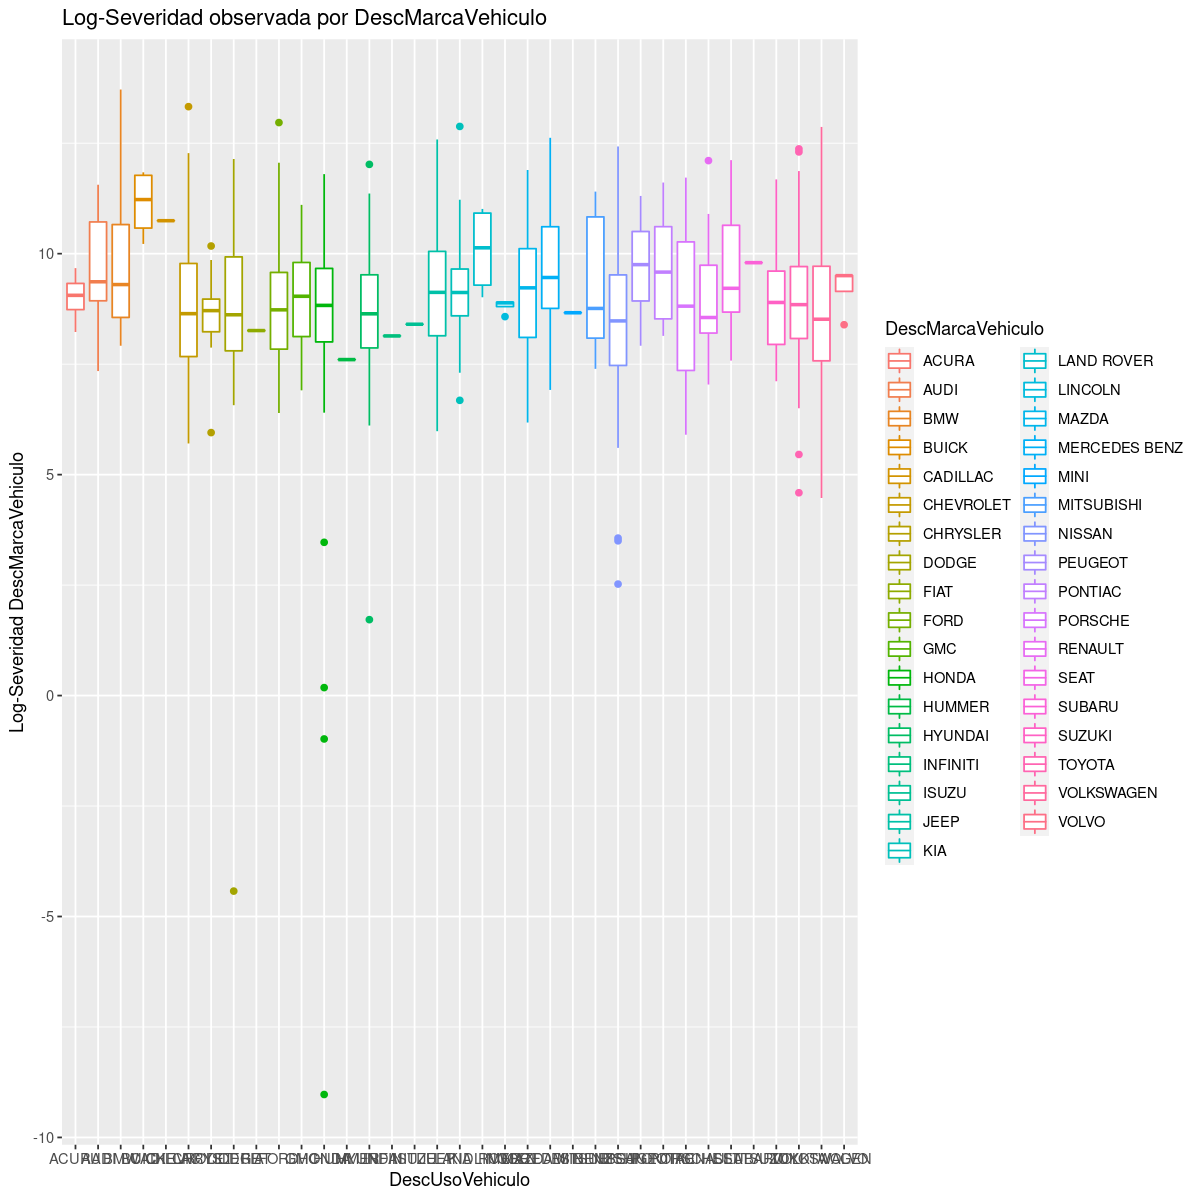

In [24]:
options(repr.plot.width = 10, repr.plot.height = 10)
img7

##### Observación.

De los diagramas anteriores, sugieren que las mejores variables que más reflejan la variabilidad de la severidad pueden ser:

- ModeloVehiculo: Muestra una tendencia creciente respecto del modelo.

- DescUsoVehiculo: Muestra una ligera diferencia entre los tipos de uso  del vehiculo, pero parece haber diferencias marcadas entre una ambulacia y el transporte de turismo.



##### Quitando variables faltantes.


In [25]:
apply(datos,2,function(x){any(is.na(x))})

Anio                          ID 
                      FALSE                       FALSE 
              NombreOficina           UnidadesExpuestas 
                      FALSE                       FALSE 
         NombreSubdireccion            DescTipoVehiculo 
                       TRUE                       FALSE 
                TipoPersona                        Edad 
                       TRUE                        TRUE 
                       Sexo           DescMarcaVehiculo 
                       TRUE                       FALSE 
     DescCarroceriaVehiculo              ModeloVehiculo 
                      FALSE                       FALSE 
            DescUsoVehiculo PrimaNetaPropiaSinCoaseguro 
                      FALSE                       FALSE 
              MontoOcurrido               NumSiniestros 
                      FALSE                       FALSE 
                      signo                     FrecObs 
                      FALSE                       FALSE 
                     SevObs                       Edadx 
                      FALSE                        TRUE

In [26]:
#quitanto NA de TipoPersona
nas = which(is.na(datos$TipoPersona))
print(paste0("Quitando ",length(nas)," observaciones."))
datos = datos[-nas,]

[1] "Quitando 84 observaciones."


In [27]:
#quitanto NA de Edad
nas = which(is.na(datos$Edad))
print(paste0("Quitando ",length(nas)," observaciones."))
datos = datos[-nas,]

[1] "Quitando 20 observaciones."


In [28]:
#quitanto NA de NombreSubdireccion
nas = which(is.na(datos$NombreSubdireccion))
print(paste0("Quitando ",length(nas)," observaciones."))
datos = datos[-nas,]

[1] "Quitando 1 observaciones."


Se conventiran los factores dentro de los datos  dummy, ya que el paquete Rfast2 require esa representación.

In [29]:
apply(datos,2,class)

Anio                          ID 
                "character"                 "character" 
              NombreOficina           UnidadesExpuestas 
                "character"                 "character" 
         NombreSubdireccion            DescTipoVehiculo 
                "character"                 "character" 
                TipoPersona                        Edad 
                "character"                 "character" 
                       Sexo           DescMarcaVehiculo 
                "character"                 "character" 
     DescCarroceriaVehiculo              ModeloVehiculo 
                "character"                 "character" 
            DescUsoVehiculo PrimaNetaPropiaSinCoaseguro 
                "character"                 "character" 
              MontoOcurrido               NumSiniestros 
                "character"                 "character" 
                      signo                     FrecObs 
                "character"                 "character" 
                     SevObs                       Edadx 
                "character"                 "character"

In [30]:
datos$Anio = as.integer(datos$Anio)
datos$Edad = as.integer(datos$Edad)
datos$ModeloVehiculo = as.integer(datos$ModeloVehiculo)

In [31]:
DescMarcaVehiculo = model.matrix( ~ DescMarcaVehiculo - 1, datos)  
dim(DescMarcaVehiculo)
head(DescMarcaVehiculo)

[1] 49608    57

,DescMarcaVehiculoACURA,DescMarcaVehiculoALFA ROMEO,DescMarcaVehiculoAUDI,DescMarcaVehiculoBAIC,DescMarcaVehiculoBMW,DescMarcaVehiculoBUICK,DescMarcaVehiculoCADILLAC,DescMarcaVehiculoCHANGAN,DescMarcaVehiculoCHEVROLET,DescMarcaVehiculoCHRYSLER,⋯,DescMarcaVehiculoSEAT,DescMarcaVehiculoSMART,DescMarcaVehiculoSPARTAK,DescMarcaVehiculoSTRUDER,DescMarcaVehiculoSUBARU,DescMarcaVehiculoSUZUKI,DescMarcaVehiculoTODAS,DescMarcaVehiculoTOYOTA,DescMarcaVehiculoVOLKSWAGEN,DescMarcaVehiculoVOLVO
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


In [32]:
colnames(DescMarcaVehiculo)

[1] "DescMarcaVehiculoACURA"         "DescMarcaVehiculoALFA ROMEO"   
 [3] "DescMarcaVehiculoAUDI"          "DescMarcaVehiculoBAIC"         
 [5] "DescMarcaVehiculoBMW"           "DescMarcaVehiculoBUICK"        
 [7] "DescMarcaVehiculoCADILLAC"      "DescMarcaVehiculoCHANGAN"      
 [9] "DescMarcaVehiculoCHEVROLET"     "DescMarcaVehiculoCHRYSLER"     
[11] "DescMarcaVehiculoCLASICO"       "DescMarcaVehiculoCUPRA"        
[13] "DescMarcaVehiculoDFSK"          "DescMarcaVehiculoDODGE"        
[15] "DescMarcaVehiculoFAW"           "DescMarcaVehiculoFIAT"         
[17] "DescMarcaVehiculoFORD"          "DescMarcaVehiculoGIANT"        
[19] "DescMarcaVehiculoGMC"           "DescMarcaVehiculoHINO"         
[21] "DescMarcaVehiculoHONDA"         "DescMarcaVehiculoHUMMER"       
[23] "DescMarcaVehiculoHYUNDAI"       "DescMarcaVehiculoINFINITI"     
[25] "DescMarcaVehiculoISUZU"         "DescMarcaVehiculoJAC"          
[27] "DescMarcaVehiculoJAGUAR"        "DescMarcaVehiculoJEEP"         
[29] "DescMarcaVehiculoKIA"           "DescMarcaVehiculoLAND ROVER"   
[31] "DescMarcaVehiculoLINCOLN"       "DescMarcaVehiculoMASERATI"     
[33] "DescMarcaVehiculoMAZDA"         "DescMarcaVehiculoMERCEDES BENZ"
[35] "DescMarcaVehiculoMERCURY"       "DescMarcaVehiculoMG"           
[37] "DescMarcaVehiculoMINI"          "DescMarcaVehiculoMITSUBISHI"   
[39] "DescMarcaVehiculoNISSAN"        "DescMarcaVehiculoPEUGEOT"      
[41] "DescMarcaVehiculoPIAGGIO"       "DescMarcaVehiculoPONTIAC"      
[43] "DescMarcaVehiculoPORSCHE"       "DescMarcaVehiculoRAM"          
[45] "DescMarcaVehiculoRENAULT"       "DescMarcaVehiculoROVER"        
[47] "DescMarcaVehiculoSAAB"          "DescMarcaVehiculoSEAT"         
[49] "DescMarcaVehiculoSMART"         "DescMarcaVehiculoSPARTAK"      
[51] "DescMarcaVehiculoSTRUDER"       "DescMarcaVehiculoSUBARU"       
[53] "DescMarcaVehiculoSUZUKI"        "DescMarcaVehiculoTODAS"        
[55] "DescMarcaVehiculoTOYOTA"        "DescMarcaVehiculoVOLKSWAGEN"   
[57] "DescMarcaVehiculoVOLVO"

In [33]:
datos$HONDA = DescMarcaVehiculo[,which(colnames(DescMarcaVehiculo) == 'DescMarcaVehiculoHONDA')]
datos$TOYOTA = DescMarcaVehiculo[,which(colnames(DescMarcaVehiculo) == 'DescMarcaVehiculoTOYOTA')]

## Modelación

Decidi modelar ambas variables con modelo Gamma - Cero Inflado por las siguientes razones:

- Si no ocurre el siniestro, las variables pueden tomar el valor 0 (que, además es la moda de los valores calculados).

- En principio ambas variables son positivas, siempre y cuando ocurra el siniestro.

El modelo Gamma - Cero Inflado combina una regresión Bernoulli, con una regresión Gamma. De esta forma, la gamma sólo se expresa si previamente la regresión Bernoulli no toma el valor cero.


Nota: Si bien, una opción modelarlos de esta manera, también se pudo haber intentado un modelo de Cuasi-verosimilitud.

### Modelo de la Frecuencia

Separando la muestra en entrenamiento y prueba

In [36]:
set.seed(1)
entrenamiento = sample(1:49608, (49608-10000))
prueba = c(1:49608)[-entrenamiento]

In [37]:
regFrec = glmmTMB(FrecObs ~   log(ModeloVehiculo)*TipoPersona + log(Anio) + HONDA + TOYOTA,
                  family=ziGamma(link="log"), 
                   ziformula= ~ log(Edad) * TipoPersona +  log(ModeloVehiculo) + log(Anio) + HONDA + TOYOTA,
                  data= datos[entrenamiento,])


Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”


### Modelo de la Severidad

In [38]:
regSevObs = glmmTMB(SevObs ~   log(ModeloVehiculo)* log(Anio) + log(Edad) + TipoPersona,
                  family=ziGamma(link="log"), 
                   ziformula= ~ log(Edad) * TipoPersona +  log(ModeloVehiculo) + log(Anio) + HONDA + TOYOTA,
                  data= datos[entrenamiento,])

Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”


## Bondad de Ajuste

In [39]:
summary(regFrec)

 Family: Gamma  ( log )
Formula:          
FrecObs ~ log(ModeloVehiculo) * TipoPersona + log(Anio) + HONDA +      TOYOTA
Zero inflation:           
~log(Edad) * TipoPersona + log(ModeloVehiculo) + log(Anio) +     HONDA + TOYOTA
Data: datos[entrenamiento, ]

     AIC      BIC   logLik deviance df.resid 
 16877.0  17014.4  -8422.5  16845.0    39591 


Dispersion estimate for Gamma family (sigma^2): 0.461 

Conditional model:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           0.21586    0.78337   0.276 0.782887    
log(ModeloVehiculo)                   0.14697    0.20254   0.726 0.468040    
TipoPersonaMoral                      5.05555    2.11675   2.388 0.016924 *  
log(Anio)                             0.17305    0.03159   5.478 4.31e-08 ***
HONDA                                -0.27089    0.08060  -3.361 0.000777 ***
TOYOTA                                0.11331    0.06077   1.865 0.062228 .  
log(ModeloVehiculo):TipoPer

In [40]:
summary(regSevObs)

 Family: Gamma  ( log )
Formula:          
SevObs ~ log(ModeloVehiculo) * log(Anio) + log(Edad) + TipoPersona
Zero inflation:          
~log(Edad) * TipoPersona + log(ModeloVehiculo) + log(Anio) +     HONDA + TOYOTA
Data: datos[entrenamiento, ]

     AIC      BIC   logLik deviance df.resid 
 36357.6  36486.4 -18163.8  36327.6    39592 


Dispersion estimate for Gamma family (sigma^2):  1.7 

Conditional model:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -11.8859     2.4262  -4.899 9.63e-07 ***
log(ModeloVehiculo)             5.9840     0.6316   9.475  < 2e-16 ***
log(Anio)                       5.3028     2.1076   2.516  0.01187 *  
log(Edad)                      -0.2844     0.1017  -2.796  0.00517 ** 
TipoPersonaMoral               -0.3780     0.1473  -2.565  0.01031 *  
log(ModeloVehiculo):log(Anio)  -1.4611     0.5434  -2.689  0.00717 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:

In [41]:
FrecP = predict(regFrec,datos[entrenamiento,], type = "response")
SevP = predict(regSevObs,datos[entrenamiento,], type = "response")

Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”


In [42]:
summary(lm(datos$FrecObs[entrenamiento]~FrecP + 0))


Call:
lm(formula = datos$FrecObs[entrenamiento] ~ FrecP + 0)

Residuals:
   Min     1Q Median     3Q    Max 
-0.301 -0.107 -0.088 -0.068 33.072 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
FrecP  0.99835    0.03674   27.18   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.696 on 39606 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01831,	Adjusted R-squared:  0.01828 
F-statistic: 738.6 on 1 and 39606 DF,  p-value: < 2.2e-16


In [43]:
summary(lm(datos$SevObs[entrenamiento]~SevP + 0))


Call:
lm(formula = datos$SevObs[entrenamiento] ~ SevP + 0)

Residuals:
   Min     1Q Median     3Q    Max 
 -5265   -855   -542   -292 903093 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
SevP  0.96588    0.05943   16.25   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10230 on 39606 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.006625,	Adjusted R-squared:  0.0066 
F-statistic: 264.1 on 1 and 39606 DF,  p-value: < 2.2e-16


## Validación cruzada

In [44]:
FrecP = predict(regFrec,datos[prueba,], type = "response")
SevP = predict(regSevObs,datos[prueba,], type = "response")

In [45]:
summary(lm(datos$FrecObs[prueba]~FrecP + 0))


Call:
lm(formula = datos$FrecObs[prueba] ~ FrecP + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2380 -0.0996 -0.0816 -0.0635 12.3132 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
FrecP  0.93610    0.06346   14.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6014 on 9999 degrees of freedom
Multiple R-squared:  0.0213,	Adjusted R-squared:  0.0212 
F-statistic: 217.6 on 1 and 9999 DF,  p-value: < 2.2e-16


In [46]:
summary(lm(datos$SevObs[prueba]~SevP + 0))


Call:
lm(formula = datos$SevObs[prueba] ~ SevP + 0)

Residuals:
   Min     1Q Median     3Q    Max 
 -2999   -504   -321   -172 302618 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
SevP  0.57937    0.07945   7.292 3.29e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6804 on 9999 degrees of freedom
Multiple R-squared:  0.00529,	Adjusted R-squared:  0.00519 
F-statistic: 53.17 on 1 and 9999 DF,  p-value: 3.287e-13


#### Predicción de todas las observaciones

In [48]:
FreqT = predict(regFrec,datos, type = "response")
SevT = predict(regSevObs,datos, type = "response")
Prima = FreqT*SevT
datos$Prima = Prima

Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”
Warning message in log(Edad):
“NaNs produced”


#### Exportando los resultados

In [49]:
write.csv(datos,file = "datos2.csv")

# Conclusiones

Se expusieron dos modelos Gamma - Cero inflado con interacciones para la Frecuencia y Severidad.

- Se identificaron como variables correlacionadas positivamente con el siniestro a:  Edad, Año, Que el vehiculo sea HONDA y Ser persona Moral (siendo la más relevante la última).

- Se identificaron como variables correlacionadas negativamente con el siniestro a: ModeloVehiculo, Que el vehiculo sea Toyota y la interacción entre ser persona moral y la edad (siendo el modelo el aspecto más relevante).

- En validación cruzada se comprobo que el modelo no tiene mucha presición (se logra explicar al rededor de un 15% de la variablilidad de la prima), pero es un modelo interpretable, por ejemplo:

- - Para la parte de la regresión logistica del modelo de severidad, un incremento de un 1\% en el valor del año, esta asociado a un incremento del 139\% en el momio del evento (ya que $\exp(0.332) \sim 1.3937$.

